In [36]:
include("../lna.jl")
include("../functions.jl")

log_likelihood_whole_cell (generic function with 2 methods)

# Inferring parameters given only the protein data.

Here we assume we have N IID measurements of the molecule count of a single protein from different cells (or the same cell at different points in time). From this data we infer the parameters.

In [2]:
N_genes = 10
rn = generate_rn(N_genes)

ps = [N_genes*100., 0.5] # [ribosome production, ribosome degredation]
for j in 1:N_genes
    ps = vcat(
        ps, 
        [
            3, # mRNA creation
            0.7, # mRNA degredation
            0.01, # binding to polysome
            0.001, # unbinding from polysome
            1.0, # translation,
            0.5, # monosome decay
            0.5 # protein decay
        ]
    )
end

prob = LNAProblem(rn, zeros(length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 100000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=100.0)

rib_counts = map(x -> x[1], sol.u)
mrna_counts = map(x -> x[2], sol.u)
rib_int_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
rib_bound_counts = map(x -> sum(x[3+3:3:length(x)]), sol.u);

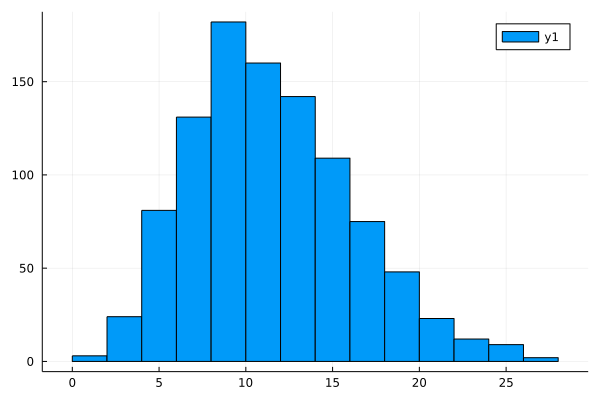

In [3]:
histogram(protein_counts)

Given the protein count data, we aim to infer parameters for each model. We will then compute the bayesian information criterion for each model and compare them.

The first model will be the canonical model.

In [4]:
lower = [0., 0., 0., 0.]
upper = [100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_can(
        protein_counts,
        x[1],
        x[2] + x[4], # ensure k2 > k6
        x[3],
        x[4]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10.]
)

 * Status: success

 * Candidate solution
    Final objective value:     2.953550e+03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.40e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.57e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.99e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   150  (vs limit Inf)
    Iterations:    25
    f(x) calls:    30715
    ∇f(x) calls:   30715


In [5]:
can_params = Optim.minimizer(x)

can_params = [can_params[1], can_params[2] + can_params[4], can_params[3], can_params[4]]

4-element Vector{Float64}:
 66.57870170435332
 50.246572790665496
 53.722300188408695
  6.47717139674764

In [6]:
can_predicted_mean = can_params[1]*can_params[3]/can_params[2]/can_params[4]
can_predicted_var = can_params[1]*can_params[3]/(can_params[2]*can_params[4]) * (1 + can_params[3]/(can_params[2] + can_params[4]))

21.398501603668382

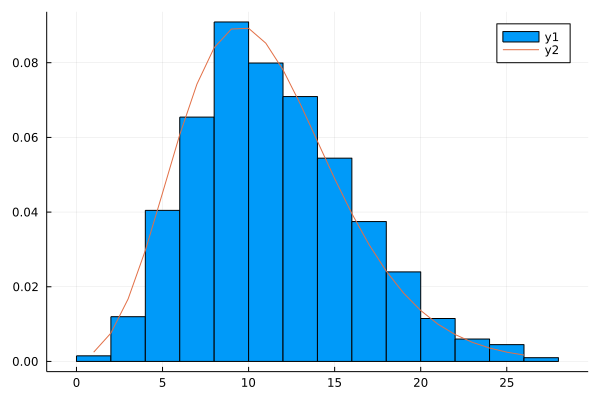

In [7]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, can_predicted_mean, can_predicted_var))

In [8]:
BIC_can = 4*log(length(protein_counts)) + 2*log_likelihood_can(protein_counts, can_params...)

5934.734184299263

In [9]:
neg_log_lik_can = log_likelihood_can(protein_counts, can_params...)

2953.549582591001

In [10]:
rn_rib_bound_f()

Model ##ReactionSystem#293 with 9 equations
States (4):
  r(t)
  m(t)
  p(t)
  rb(t)
Parameters (9):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

Next for the bound model. This model has 9 parameters, but some are replicated.

In [11]:
lower = [0., 0., 0., 0., 0., 0., 0.]
upper = [100, 100, 100, 100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_rib_bound(
        protein_counts,
        x[1],
        x[2],
        x[3],
        x[2] + x[4],
        x[5],
        x[2],
        x[6],
        x[7],
        x[2]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10., 10., 10., 10.]
)

 * Status: success (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     2.953550e+03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.22e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.02e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.74e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   1541  (vs limit Inf)
    Iterations:    36
    f(x) calls:    68184
    ∇f(x) calls:   68184


In [12]:
bound_params = Optim.minimizer(x)

bound_params = [
    bound_params[1], 
    bound_params[2], 
    bound_params[3], 
    bound_params[2] + bound_params[4], 
    bound_params[5], 
    bound_params[2],
    bound_params[6],
    bound_params[7],
    bound_params[2]
]

9-element Vector{Float64}:
 58.427509467982766
  3.8204291811114572
 70.2509438160314
 73.17402651440543
  7.2317749499912605
  3.8204291811114572
 61.86403248675106
 36.64214142863926
  3.8204291811114572

In [13]:
rn_bound = rn_rib_bound_f()
prob = LNAProblem(rn_bound, zeros(length(species(rn_bound))), bound_params)
sol = solve(prob)
lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

4×4 Matrix{Float64}:
 6.04742      0.0        2.29244   8.88178e-15
 0.0          0.960053   0.545319  0.0
 2.29244      0.545319  21.3985    3.20257
 8.88178e-15  0.0        3.20257   9.24602

In [14]:
bound_predicted_mean = lnameans[3]
bound_predicted_cov = lnacovs[3,3]

21.398497298795903

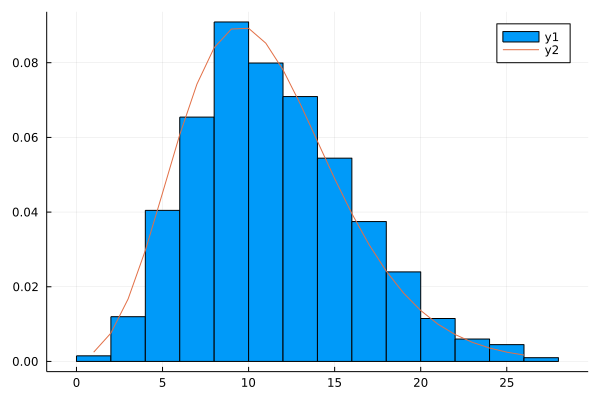

In [15]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, bound_predicted_mean, bound_predicted_cov))

In [16]:
neg_log_lik_bound = log_likelihood_rib_bound(protein_counts, bound_params...)

2953.549582591004

In [17]:
BIC_bound = 7*log(length(protein_counts)) + 2*log_likelihood_rib_bound(protein_counts, bound_params...)

5955.4604486372145

Now for the bound int model.

In [18]:
rn_rib_bound_int_f()

Model ##ReactionSystem#294 with 12 equations
States (5):
  r(t)
  m(t)
  rs(t)
  p(t)
  rb(t)
Parameters (12):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [19]:
lower = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
upper = [100, 100, 100, 100, 100, 100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_rib_bound_int(
        protein_counts,
        x[1],
        x[2],
        x[3],
        x[2] + x[4],
        x[5],
        x[6],
        x[7],
        x[2],
        x[2],
        x[8],
        x[9],
        x[2]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10., 10., 10., 10., 10., 10.]
)
can_params = Optim.minimizer(x);

In [20]:
bound_int_params = Optim.minimizer(x)

bound_int_params = [
    bound_int_params[1], 
    bound_int_params[2], 
    bound_int_params[3], 
    bound_int_params[2] + bound_int_params[4], 
    bound_int_params[5], 
    bound_int_params[6],
    bound_int_params[7],
    bound_int_params[2],
    bound_int_params[2],
    bound_int_params[8],
    bound_int_params[9],
    bound_int_params[2]
]

12-element Vector{Float64}:
 65.42831084697188
  6.979621013221033
 67.46132900376493
 48.02761788772651
 55.63868044899303
 48.472392504458234
 30.233161889774976
  6.979621013221033
  6.979621013221033
 48.47548053670199
 52.66934301558674
  6.979621013221033

In [21]:
rn_bound_int = rn_rib_bound_int_f()
prob = LNAProblem(rn_bound_int, zeros(length(species(rn_bound_int))), bound_int_params)
sol = solve(prob)
lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

bound_int_predicted_mean = lnameans[4]
bound_int_predicted_cov = lnacovs[4,4]

21.39850097850248

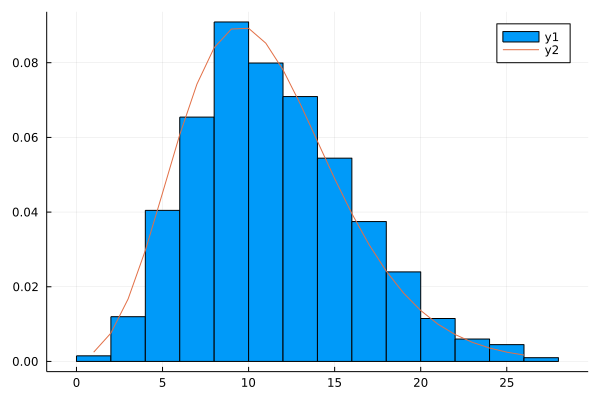

In [22]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, bound_int_predicted_mean, bound_int_predicted_cov))

In [23]:
neg_log_lik_bound_int = log_likelihood_rib_bound_int(protein_counts, bound_int_params...)

2953.5495825910007

In [24]:
BIC_bound_int = 9*log(length(protein_counts)) + 2*log_likelihood_rib_bound_int(protein_counts, bound_int_params...)

5969.277958195838

Finally we infer the parameters for the whole cell model. This will take a long time due to the large number of parameters.

In [ ]:
rn_wc = generate_rn(N_genes)
N_params = length(reactions(rn_wc))

lower = zeros(N_params)
upper = zeros(N_params) .+ 100.


# Here it is not possible to constrain mrna degredation to be greater than protein degredation. At least not easily possible.
# This will take a loooong time to run!!!
x = optimize(
    x -> log_likelihood_whole_cell(
        protein_counts,
        x
    ), 
    lower, 
    upper, 
    zeros(N_params) .+ 10.
)

wc_params = Optim.minimizer(x)

In [ ]:
prob = LNAProblem(rn_wc, zeros(length(species(rn_wc))), wc_params)
sol = solve(prob)
lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

wc_predicted_mean = lnameans[4]
wc_predicted_cov = lnacovs[4,4]

In [ ]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, wc_predicted_mean, wc_predicted_cov))

# Inferring parameters with protein + mRNA data

In [20]:
N_genes = 10
rn = generate_rn(N_genes)

ps = [N_genes*100., 0.5] # [ribosome production, ribosome degredation]
for j in 1:N_genes
    ps = vcat(
        ps, 
        [
            5, # mRNA creation
            0.7, # mRNA degredation
            0.01, # binding to polysome
            0.001, # unbinding from polysome
            1.0, # translation,
            0.5, # monosome decay
            0.5 # protein decay
        ]
    )
end

prob = LNAProblem(rn, zeros(length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 20000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=100.0)

rib_counts = map(x -> x[1], sol.u)
mrna_counts = map(x -> x[2], sol.u)
rib_int_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
rib_bound_counts = map(x -> sum(x[3+3:3:length(x)]), sol.u);

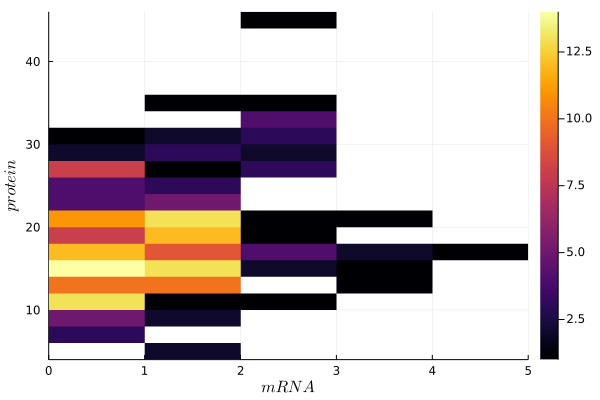

In [21]:
histogram2d(mrna_counts, protein_counts, xlabel=L"mRNA", ylabel=L"protein", nbins=(5, 20))

In [22]:
lower = [0., 0., 0., 0.]
upper = [100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_can(
        mrna_counts,
        protein_counts,
        x[1],
        x[2] + x[4], # ensure k2 > k6
        x[3],
        x[4]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10.]
)

 * Status: success

 * Candidate solution
    Final objective value:     8.970134e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.57e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.70e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   247  (vs limit Inf)
    Iterations:    17
    f(x) calls:    37938
    ∇f(x) calls:   37938


In [23]:
can_params = Optim.minimizer(x)

can_params = [can_params[1], can_params[2] + can_params[4], can_params[3], can_params[4]]

can_predicted_mean = can_params[1]*can_params[3]/can_params[2]/can_params[4]
can_predicted_var = can_params[1]*can_params[3]/(can_params[2]*can_params[4]) * (1 + can_params[3]/(can_params[2] + can_params[4]))

43.35891756060088

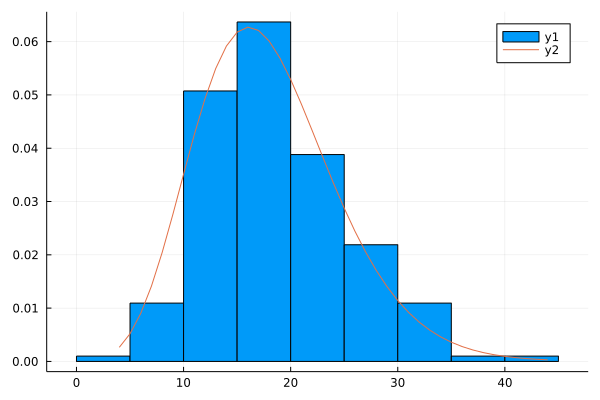

In [24]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, can_predicted_mean, can_predicted_var))

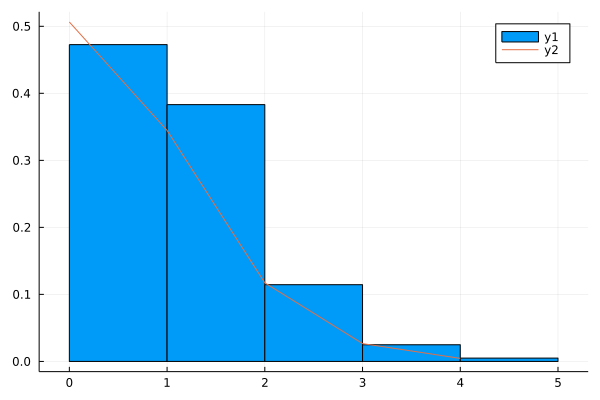

In [38]:
xs = minimum(mrna_counts):1:maximum(mrna_counts)
histogram(mrna_counts, norm=true, nbins=length(xs))

mrna_mean = can_params[1]/can_params[2]
plot!(xs, poisson_ys(xs, mrna_mean))

In [42]:
neg_log_lik_can = log_likelihood_can(
    mrna_counts,
    protein_counts,
    can_params...
)

897.0133957703587

In [43]:
BIC_can = 4*log(length(protein_counts)) + 2*log_likelihood_can(mrna_counts, protein_counts, can_params...)

1815.2400111729537

In [47]:
lower = [0., 0., 0., 0., 0., 0., 0.]
upper = [50, 50, 50, 50, 50, 50, 50]

x = optimize(
    x -> log_likelihood_rib_bound(
        mrna_counts,
        protein_counts,
        x[1],
        x[2],
        x[3],
        x[2] + x[4],
        x[5],
        x[2],
        x[6],
        x[7],
        x[2]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10., 10., 10., 10.]
)

LoadError: InterruptException:

In [48]:
bound_params = Optim.minimizer(x)

bound_params = [
    bound_params[1], 
    bound_params[2], 
    bound_params[3], 
    bound_params[2] + bound_params[4], 
    bound_params[5], 
    bound_params[2],
    bound_params[6],
    bound_params[7],
    bound_params[2]
]

LoadError: BoundsError: attempt to access 4-element Vector{Float64} at index [5]

In [49]:
rn_bound = rn_rib_bound_f()
prob = LNAProblem(rn_bound, zeros(length(species(rn_bound))), bound_params)
sol = solve(prob)
lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

LoadError: BoundsError: attempt to access 4-element Vector{Float64} at index [5]